In [1]:
# Sarcini:
# - Scrierea și comentarea codului.
#  - Implimentarea clasei Data set.  
#  - Implimentarea rețelei neuronale.
#  - Implimentarea ciclului de învățarea.
#  - Prezența grficului  - Learning Curve pe acuratete și eroare.
#  - Reantrenarea modelului cu cel mai bun rezultat dupa learning curve.


#Important imports
from numpy.core.fromnumeric import argmax
import torch
from torch import nn as nn
from torch.utils.data import Dataset
from torch import optim 
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from torch.nn import functional as F

#Choosing devide to be gpu if have one, else cpu
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  


c:\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
#Creaating DataSet class with which we will transform our tabelar data into tensors
class DataSet(Dataset):

    def __init__(self,file_name):  
        #transformed csv file into tensor
        self.dataset = torch.tensor(pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'heart',file_name)).values)

    def __len__(self):
        #return lenght of dataset
        return len(self.dataset)

    def __getitem__(self, i):
        #returns X and Y data by index
        return self.dataset[i,:-1], self.dataset[i,-1]            ## mb add transformation that normalizes

In [3]:
class Net(nn.Module):

    def __init__(self, n_features):
        super().__init__()
        #Setting number of initial features, which will be equal to number of features in dataset
        self.n_features = n_features
        
        #self.norm = nn.LayerNorm(n_features)
        #Setting some layers for our architecture
        self.fc1 = nn.Linear(self.n_features,16) # (input, ouput)
        self.fc2 = nn.Linear(16,32) # (input, ouput)
        self.fc3 = nn.Linear(32,1)  # (input, ouput)           

    def forward(self,x):
        #Running forward cycle of our network
        out = F.silu(self.fc1(x))
        out = F.silu(self.fc2(out))
        out = F.sigmoid(self.fc3(out))
        
        #returning ouput
        return out

In [4]:
# Training loop for our network
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader, l2=0.001, print_plot=True):

    #Initializing two lists to save loses to plot them later
    train_loses = []
    val_loses = []

    #Going thru every epoch
    for epoch in range(1,n_epochs+1):

        #Setting loss to 0 at the begginng of every epoch
        train_loss = 0.0
        val_loss = 0.0

        #Going thru example, thru every batch, in our case, thru all data at once
        for example, labels in train_loader:     

            #Translating calculations to gpu if is available
            example = example.to(DEVICE)
            labels = labels.to(DEVICE)

            # ensuring equal number of dimensions for labels and examples
            labels  = labels.unsqueeze(1)

            # running our data thru our data - forward
            train_output = model(example.float())
            # Getting loss of our network right now
            train_loss += loss_fn(train_output, labels.float())

            
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            train_loss = train_loss + l2 *l2_norm

            # Zeroing the gradient to not stack it from other iterations
            optimizer.zero_grad()
            #Runing backward part of the neural network, getting gradiets
            train_loss.backward()
            #Updating our paramters
            optimizer.step()

        #Running over validation data
        for example, labels in val_loader:

            #Translating calculations to gpu if is available
            example = example.to(DEVICE)
            labels = labels.to(DEVICE)
            
            # ensuring equal number of dimensions for labels and examples
            labels  = labels.unsqueeze(1)

            #Forward
            val_output = model(example.float())
            #Loss
            val_loss += loss_fn(val_output, labels.float())


        #Print results for epochs
        if epoch == 1 or epoch % 5 == 0:
            print('Epoch {0}, Training loss - {1}, Validation loss {2}'.format(epoch,train_loss, val_loss))

        # Append losses to lists
        train_loses.append(train_loss)
        val_loses.append(val_loss)

    #If set to True, print graph of train and validation loss
    if print_plot:

        #Setting x-ticks
        epochs = range(1,n_epochs+1)

        #Ploting both curves, train and val 
        plt.plot(epochs, train_loses, 'g', label='Training loss')
        plt.plot(epochs, val_loses, 'b', label='validation loss')
        plt.title('Training and Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [5]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

#Creating Dataset from csv file
data = DataSet('heart.csv')

#Saving nr of examples and calculating number of validation samples
n_samples = len(data)
n_val = int(0.2*n_samples)

#Spliting into train and validation
train_set, val_set = torch.utils.data.random_split(data,  [n_samples-n_val, n_val])


# running train and validation sets thru dataloader that helps with parallelizing the data loading process with automatic batching
train_loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=len(val_set), shuffle=True)


c:\python38\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1, Training loss - 0.6033933162689209, Validation loss 2.3540682792663574
Epoch 5, Training loss - 1.4667456150054932, Validation loss 1.185074806213379
Epoch 10, Training loss - 0.8838014602661133, Validation loss 0.7574082016944885
Epoch 15, Training loss - 0.7089419364929199, Validation loss 0.7552868723869324
Epoch 20, Training loss - 0.6250907778739929, Validation loss 0.6441836357116699
Epoch 25, Training loss - 0.5914239883422852, Validation loss 0.6484807729721069
Epoch 30, Training loss - 0.5722503662109375, Validation loss 0.6298453211784363
Epoch 35, Training loss - 0.5606216192245483, Validation loss 0.6385287642478943
Epoch 40, Training loss - 0.5491718053817749, Validation loss 0.6403273940086365
Epoch 45, Training loss - 0.538561224937439, Validation loss 0.6381595730781555
Epoch 50, Training loss - 0.5277984738349915, Validation loss 0.633934497833252
Epoch 55, Training loss - 0.5159181356430054, Validation loss 0.6274162530899048
Epoch 60, Training loss - 0.49891

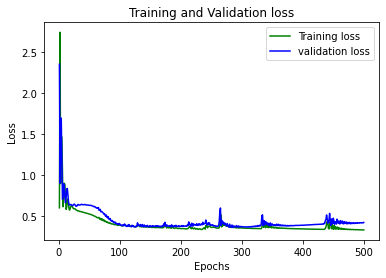

In [6]:
#Setting some hyperparameters and parameters
learning_rate = 1e-2

#Initializing model with nr of features from input
model = Net(len(data[0][0])).to(DEVICE)

#Optimizer and loss funtion
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()                                                     

#Running training loop on the data with set parameters
training_loop(
    n_epochs=500,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    val_loader = val_loader
)


Epoch 1, Training loss - 47.3430061340332, Validation loss 38.333335876464844
Epoch 5, Training loss - 6.381654739379883, Validation loss 2.2227935791015625
Epoch 10, Training loss - 1.090625524520874, Validation loss 1.1279963254928589
Epoch 15, Training loss - 1.0156981945037842, Validation loss 0.8169170618057251
Epoch 20, Training loss - 0.7288892865180969, Validation loss 0.6418871879577637
Epoch 25, Training loss - 0.6185771226882935, Validation loss 0.656998336315155
Epoch 30, Training loss - 0.6360617280006409, Validation loss 0.6748867630958557
Epoch 35, Training loss - 0.5807546377182007, Validation loss 0.6620100736618042
Epoch 40, Training loss - 0.5700724720954895, Validation loss 0.6356956362724304
Epoch 45, Training loss - 0.5546671152114868, Validation loss 0.6421913504600525
Epoch 50, Training loss - 0.5344627499580383, Validation loss 0.6498194932937622
Epoch 55, Training loss - 0.5239614844322205, Validation loss 0.6341128349304199
Epoch 60, Training loss - 0.5092459

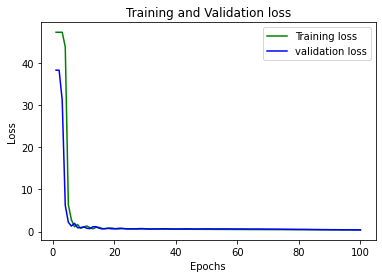

In [7]:
#Renewing our model to run it for more efficient number of epochs


# for layer in model.children():
#    if hasattr(layer, 'reset_parameters'):                                                           ######### idk
#        layer.reset_parameters()

model = Net(len(data[0][0])).to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
 

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    val_loader = val_loader
)

In [8]:
# print(val_set[:][0].float().to(DEVICE))
# from sklearn.metrics import accuracy_score
# pred_test = model(val_set[:][0].float().to(DEVICE))
# preds_y = pred_test.argmax().to(DEVICE)
# accuracy_score(val_set[:][1].float().to(DEVICE), preds_y)